<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Intuition on synergy & redundancy

***

FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

***

**Context**

With the advanced capabilities FACET provides by extending SHAP-based model inspection, it is important to **gain some intuition for how the newly introduced measures for feature redundancy and synergy can vary**. As SHAP values represent post-processing after data preparation, feature engineering, preprocessing and model selection/tuning, minimal simulation studies offer a way to make the connection as direct as possible.

In this FACET tutorial we will conduct two simulation studies to gain intuition about synergy and redundancy:

1. Explore patterns in synergy and redundancy as a function of the individual and joint contribution of two continuous features in predicting a binary target where the features have varying degrees of correlation.
2. Explore how overfitting affects the accuracy of redundancy and synergy estimates for a random forest classifier by varying the `max_depth` parameter.

***

**Tutorial outline**

1. [Required imports](#Required-imports)
2. [Simulating data](#Simulating-data)
3. [SHAP, Redundancy and Synergy](#SHAP,-Redundancy-and-Synergy)
4. [Understanding how redundancy and synergy change with feature correlation and interaction](#Understanding-how-redundancy-and-synergy-change-with-feature-correlation-and-interaction)
5. [How overfitting affects the accuracy of redundancy and synergy estimates](#How-overfitting-affects-the-accuracy-of-redundancy-and-synergy-estimates)
6. [Summary](#Summary)
7. [What can you do next?](#What-can-you-do-next?)
8. [Appendix](#Appendix)

In [6]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx


# ignore irrelevant warnings that would affect the output of this tutorial notebook

import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")
warnings.filterwarnings("ignore", message=r".*`should_run_async` will not call `transform_cell`")
warnings.filterwarnings("ignore", message=r".*`np\..*` is a deprecated alias")


# set global options for matplotlib

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
matplotlib.rcParams["figure.dpi"] = 72

# Required imports

In order to run this notebook, we will import not only the FACET package, but also other packages useful to solve this task. Overall, we can break down the imports into three categories: 

1. Common packages (pandas, matplotlib, etc.)
2. Required FACET classes (inspection, selection, validation, simulation, etc.)
3. sklearndf a BCG GAMMA package that simplifies pipelining (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)).

**Common package imports**

In [7]:
import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import shap
import itertools
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import RepeatedKFold

**FACET imports**

In [8]:
from facet.data import Sample
from facet.crossfit import LearnerCrossfit
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV

**sklearndf imports**

Instead of using the \"regular\" scikit-learn package, we are going to use sklearndf (see on [GitHub](https://github.com/BCG-Gamma/sklearndf/)). sklearndf is an open source library designed to address a common issue with scikit-learn: the outputs of transformers are numpy arrays, even when the input is a data frame. However, to inspect a model it is essential to keep track of the feature names. sklearndf retains all the functionality available through scikit-learn plus the feature traceability and usability associated with Pandas data frames. Additionally, the names of all your favourite scikit-learn functions are the same except for DF on the end. For example, the standard scikit-learn import:

`from sklearn.pipeline import Pipeline`

becomes:

`from sklearndf.pipeline import PipelineDF`

In [18]:
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF, RegressorPipelineDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.regression.extra import LGBMRegressorDF

# Simulating data

When analysing data, features are often [correlated](https://en.wikipedia.org/wiki/Correlation_and_dependence) (degree to which two features are related) or [interact](https://en.wikipedia.org/wiki/Interaction_(statistics)) with each other (the combined features improve prediction performance). As part of a robust data science process, identifying and understanding the impact these data characteristics have on a predictive model, and hence conclusions, is important. 

To demonstrate how the capabilities of FACET’s novel algorithm can help with this task, this tutorial uses simulation to control the characteristics of our data and then see how these are reflected in our inspection using FACET.

We use the following data generating process to simulate data for this tutorial:

- Step 1. Generate a pair of features $X_1$ and $X_2$, from a standard normal distribution with linear correlation ($\rho$). Importantly rho controls the extent of linear correlation between the two features.

- Step 2: Generate the linear predictor $lp$ using pre-defined coefficients $\beta_0$, $\beta_1$, $\beta_2$, $\beta_3$. Importantly $\beta_3$ controls the contribution of the interaction between the two features ($X_1 \times X_2$).

In the case of regression:

- Step 3: Generate the target variable (y) using the linear predictor plus error, where the error follows a standard normal distribution.

Or in the case of classification:

- Step 3: Generate the probability of the outcome using the [expit](https://www.rdocumentation.org/packages/rgr/versions/1.1.15/topics/expit) transformation of the linear predictor.

- Step 4: Convert the probability of the outcome to a 0/1 target variable (y) by simulating from a uniform random variable and comparing with the probability. Where U is less than p we set a value of 1 for the target and 0 otherwise.

This process provides a dataset with two features and a target binary variable which we can predict using a classifier. Further, the simulated dataset will have a determined amount of correlation and interaction between the two features $X_1$ and $X_2$.

The function used to simulate data according to the above specifications is `sim_interaction()` and can be found in the [Appendix](#Data-simulation-code).

$$ (X_1, X_2) \sim N\left[\left(\begin{array}{c} 0\\0 \end{array}\right), \left(\begin{array}{cc} 1 & \rho\\ \rho & 1 \end{array}\right)\right]$$
   
$$ lp =  \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2  $$

For regression:

$$e \sim \textrm{N}(0,1)$$

$$y = lp + e $$

For classification:

$$p = \cfrac{1}{1 + exp(-lp)}$$
    
$$U \sim \textrm{U}(0,1)$$
    
    
$$y = \begin{cases}
1 & U < p  \\
0 & U \geq p
\end{cases}$$

Importantly we use the [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) $\rho$  (degree to which two features are linearly related) between features to induce redundancy, and the balance between an interaction ($\beta_3$) and main effects ($\beta_1, \beta_2$) to induce synergy. For example, as the correlation gets higher, we expect higher redundancy, and as the interaction gets stronger and the main effects get weaker, we expect higher synergy.

The function used to simulate data according to the above specifications is `sim_interaction()` and can be found in the [Appendix](#Data-simulation-code).

# SHAP, Redundancy and Synergy

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for each observation (i.e., explain **individual** predictions).

The FACET `LearnerInspector` computes SHAP values for each crossfit (i.e., a CV fold or bootstrap resample) using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding pairwise feature redundancy and synergy. Redundancy and synergy are calculated using a new algorithm to understand model predictions from a **global perspective** to complement local SHAP.

The definitions of synergy and redundancy are as follows:


- **Synergy**

  The degree to which the model combines information from one feature with 
  another to predict the target. For example, let's assume we are predicting 
  cardiovascular health using age and gender and the fitted model includes 
  a complex interaction between them. This means these two features are 
  synergistic for predicting cardiovascular health. Further, both features 
  are important to the model and removing either one would significantly 
  impact performance. Let's assume age brings more information to the joint
  contribution than gender. This asymmetric contribution means the synergy for
  $(\mathit{age}, \mathit{gender})$ is less than the synergy for
  $(\mathit{gender}, \mathit{age})$. To think about it
  another way, imagine the prediction is a coordinate you are trying to reach.
  From your starting point, age gets you much closer to this point than 
  gender, however, you need both to get there. Synergy reflects the fact 
  that gender gets more help from age (higher synergy from the perspective 
  of gender) than age does from gender (lower synergy from the perspective of
  age) to reach the prediction. *This leads to an important point: synergy 
  is a naturally asymmetric property of the global information two interacting 
  features contribute to the model predictions.* Synergy is expressed as a 
  percentage ranging from 0% (full autonomy) to 100% (full synergy).


- **Redundancy**

  The degree to which a feature in a model duplicates the information of a 
  second feature to predict the target. For example, let's assume we had 
  house size and number of bedrooms for predicting house price. These 
  features capture similar information as the more bedrooms the larger 
  the house and likely a higher price on average. The redundancy for 
  $(\mathit{number\ of\ bedrooms}, \mathit{house\ size})$ will be greater
  than the redundancy for $(\mathit{house\ size}, \mathit{number\ of\ bedrooms})$.
  This is because house size "knows" more of what number of bedrooms does
  for predicting house price than vice-versa.
  Hence, there is greater redundancy from the perspective 
  of number of bedrooms. Another way to think about it is removing house 
  size will be more detrimental to model performance than removing number 
  of bedrooms, as house size can better compensate for the absence of 
  number of bedrooms. This also implies that house size would be a more 
  important feature than number of bedrooms in the model. *The important 
  point here is that like synergy, redundancy is a naturally asymmetric 
  property of the global information feature pairs have for predicting 
  an outcome.* Redundancy is expressed as a percentage ranging from 0% 
  (full uniqueness) to 100% (full redundancy).


In brief, redundancy represents the shared information between two features and synergy represents the degree to which one feature combines with another to generate a prediction. It is also important to recognize:


 - that any pair of features may have both redundancy and synergy.
 - that **SHAP values are dependent upon the model, they represent what the model catches about reality, not the reality**. For example, underfitting or overfitting will influence redundancy and synergy.
 - If two features $A$ and $B$ both contribute to predictions of a model, then correlation translates to redundancy and interaction translates to synergy.

# Understanding how redundancy and synergy change with feature correlation and interaction

Now that we have a methodology to build a dataset with more or less correlation, main feature effects and combined (interaction) effects, we will evaluate how FACET's synergy and redundancy values will change depending on the dataset. 
To explore how redundancy only changes we use the following parameters for data generation: 


- intercept ($\beta_0$) = `[0]`
- main effects ($\beta_1, \beta_2$) = `[(0.5, 4), (1, 3), (2, 2), (3, 1), (4, 0.5)]`
- interaction ($\beta_3$) = `[0, 1, 2, 4]`
- correlation ($\rho$) = `[0.2, 0.5, 0.8]`

For each combination of parameters above we simulate 20 datasets with 1000 observations. Model fitting is performed using 10 repeated 5-fold CV. The learner is a Random Forest regressor with default hyperparameters.

The code used to generate the data presented is shown in the [Appendix](#Simulation-study-1A-code). You can experiment with the code and perform your own simulation studies, just be aware that it may take a little time to run.

## Synergy

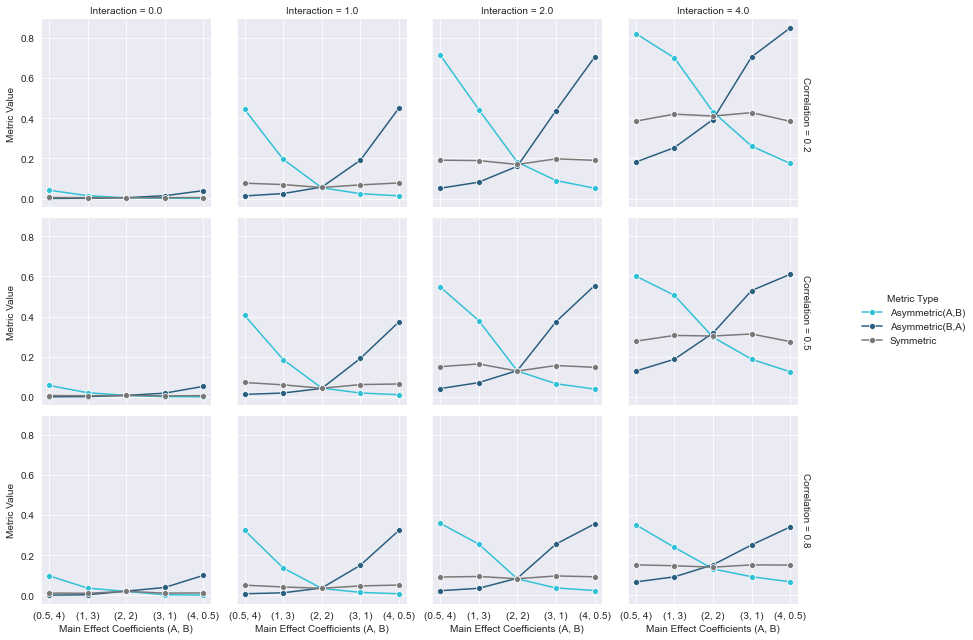

In [49]:
long_sim1_data = pd.read_csv("regression_sim1.csv")

# create summary plot
sns.set_palette(["#30c1d7", "#295e7e", "#787878"])
g = sns.FacetGrid(
    data=long_sim1_data[long_sim1_data['FACET Metric'] == 'Synergy'],
    col="Interaction",
    row='Correlation',
    hue="Metric Type",
    margin_titles=True,
)
g.map(
    sns.lineplot,
    "x_val",
    "Metric Value",
    estimator="mean",
    marker="o",
    ci=None,
)
g.set(xticks=[0, 1, 2, 3, 4])
g.set(xticklabels=['(0.5, 4)', '(1, 3)', '(2, 2)', '(3, 1)', '(4, 0.5)'])
g.add_legend()
g.set_axis_labels("Main Effect Coefficients (A, B)")
g.tight_layout()

What are the key takeaways from this figure?

1. In general as the interaction becomes stronger the synergy increases (relative to the same main effects and correlation).
2. In general as the correlation increases synergy decreases (relative to the same main effects and interaction).
3. In the case with the greatest difference on contribution by the features, for example main effect coefficients $A = 0.5$ and $B = 4$, the $\mathit{synergy}(A, B) > \mathit{synergy}(B, A)$ as feature B contributes the most to the combined prediction and so A gets more help from B (than vice-versa) for the model predictions.

## Redundancy

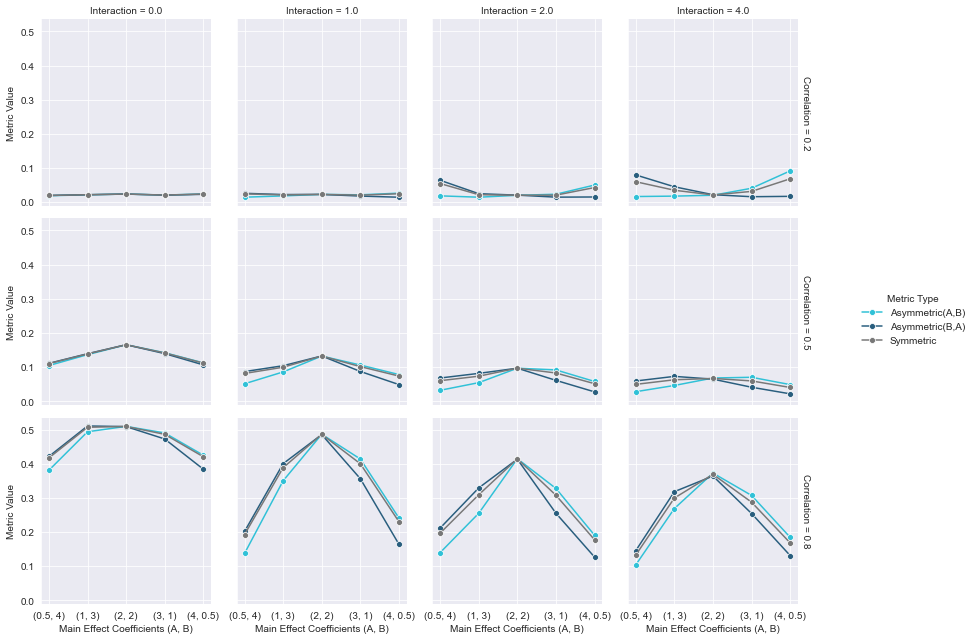

In [50]:
# create summary plot
sns.set_palette(["#30c1d7", "#295e7e", "#787878"])
g = sns.FacetGrid(
    data=long_sim1_data[long_sim1_data['FACET Metric'] == 'Redundancy'],
    col="Interaction",
    row='Correlation',
    hue="Metric Type",
    margin_titles=True,
)
g.map(
    sns.lineplot,
    "x_val",
    "Metric Value",
    estimator="mean",
    marker="o",
    ci=None,
)
g.set(xticks=[0, 1, 2, 3, 4])
g.set(xticklabels=['(0.5, 4)', '(1, 3)', '(2, 2)', '(3, 1)', '(4, 0.5)'])
g.add_legend()
g.set_axis_labels("Main Effect Coefficients (A, B)")
g.tight_layout()

What are the key takeaways from this figure?

1. In general as the correlation increases the redundancy increases (relative to the same main effects and interaction).
2. In general as the interaction increases the redundancy decreases (relative to the same main effects and correlation).
3. In the case with the greatest difference on contribution by the features, for example main effect coefficients $A = 0.5$ and $B = 4$, the $\mathit{redundancy}(A, B) > \mathit{redundancy}(B, A)$ as feature $B$ "knows" more of what feature $A$ does than vice-versa. In other words the model can tolerate loosing the information in $A$ but not in $B$.

Some additional points to keep in mind:

- Removing a redundant feature is unlikely to significantly reduce predictive performance, whereas removing a synergistic feature could significantly reduce predictive performance.

- The example here uses linear correlation and interactions for simplicity. However, if the correlation or interaction between two features is non-linear this may not be identified through a typical exploratory data analysis.

- For both correlation and interaction, the extent to which they are reflected in the redundancy or synergy for two features depends upon the fitted model. For example, if there is an interaction but the model does not learn this during training, then synergy will correspondingly be minimal.

# How overfitting affects the accuracy of redundancy and synergy estimates

In this second simulation study we are going to explore the values of synergy and redundancy as a function of regularization in a random forest. **Note that for the sake of simplicity we will utilise the symmetric definitions of synergy and redundancy**. 

The main regularization parameter is the `max_depth`, which controls the tree depth. In general, the deeper the tree the more likely we are to overfit the data. Because we will apply cross-validation we can get a sense of how model performance improves and then degrades with `max_depth` using the cross-validation curve.

For this second simulation case study, we use the following parameters for data generation:

- intercept ($\beta_0$) = `[0]`
- main effects ($\beta_1, \beta_2$) = `[1]`
- interaction ($\beta_3$) = `[3]`
- correlation ($\rho$) = `[0.5]`

We simulate 20 datasets with 1000 observations. The classifier used is a Random Forest with default hyperparameters, except as follows:

- `max_depth = [2, 4, 8, 16, 32]`
- `n_estimators = [250]`

For each combination of parameters above we perform model fitting using 10 repeated 5-fold CV for each of the 20 simulated datasets.

The code used to generate the data presented is shown in the [Appendix](#Simulation-study-2-code). You can experiment with that code and perform your own simulation studies.

(0.0, 0.547084539212145)

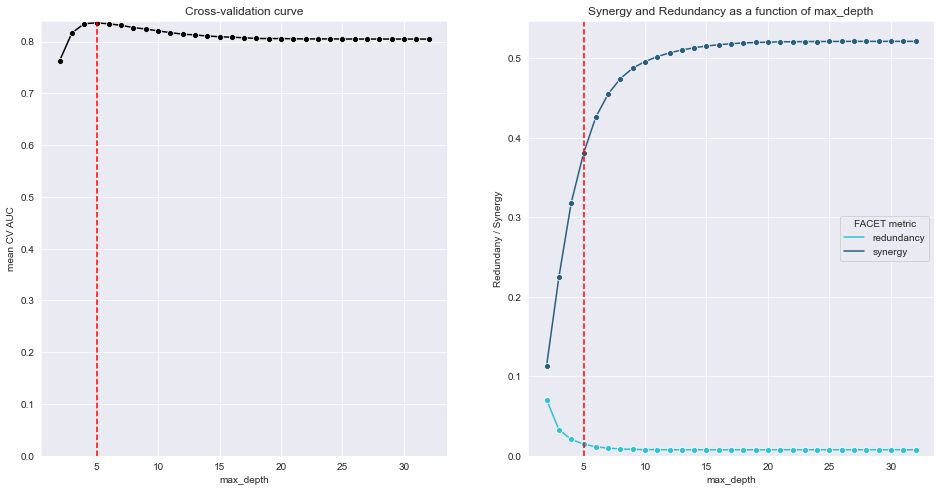

In [8]:
# load simulation study data
val_curve_df = pd.read_csv("classification_sim2_cvcurve.csv")
sim2_data = pd.read_csv("classification_sim2.csv").set_index(["max_depth", "n_estimators"])
long_sim2_data = sim2_data[["redundancy", "synergy"]].stack().reset_index()
long_sim2_data.rename(
    columns={"level_2": "FACET metric", 0: "Redundany / Synergy"}, inplace=True
)
best_max_depth = val_curve_df.loc[val_curve_df["score"].idxmax(), "max_depth"]

# plot cross-validation curve from Learner Ranker
plt.subplots(figsize=(16, 8))
plt.subplot(1, 2, 1)
ax = sns.lineplot(
    x="max_depth",
    y="score",
    data=val_curve_df,
    marker="o",
    color="black")
ax.set(xlabel="max_depth", ylabel="mean CV AUC", title="Cross-validation curve")
ax.axvline(x=best_max_depth, color="red", linestyle="--")
ax.set_ylim(bottom=0)

# create plot for redundancy and synergy as a function of max_depth
plt.subplot(1, 2, 2)
sns.set_palette(["#30c1d7", "#295e7e"])
ax = sns.lineplot(
    x="max_depth",
    y="Redundany / Synergy",
    data=long_sim2_data,
    hue="FACET metric",
    estimator="mean",
    marker="o",
    ci=None,
)
ax.set(title="Synergy and Redundancy as a function of max_depth")
ax.axvline(x=best_max_depth, color="red", linestyle="--")
ax.set_ylim(bottom=0)

We can observe the following from the figure above:

1. Based on the cross-validation curve, the best choice of `max_depth` is 5.
2. The value of synergy at the best `max_depth` of 5 is around 38% which is lower than the largest estimate of 53% when we overfit (right of `max_depth` = 5), and much greater than the smallest estimate of 12% when we underfit (left of `max_depth` = 5).
3. The value of redundancy at the best `max_depth` of 5 is around 4% which is higher than the smallest estimate of 1% when we overfit (right of `max_depth` = 5), and lower than the highest estimate of 7% when we underfit (left of `max_depth` = 5).

This suggests for a pair of moderately correlated features with a moderate interaction and limited individual contributions, overfitting might cause us to over-estimate synergy (i.e., the model interprets noise as an interaction) and under-estimate redundancy, while underfitting can cause the opposite. As with all machine learning, identifying a well-tuned model is critical to obtaining appropriate estimates of synergy and redundancy.

# Summary

We conducted two simulation studies using a simple controlled setting where we knew the amount of correlation, individual and combined contributions to a binary target.

- In the first simulation study we saw that the amount of correlation between two features as well as the strength of combined and independent contributions drive the balance between synergy and redundancy. 
- In the second simulation study we saw how both synergy and redundancy changed as a function of the `max_depth` parameter of our Random Forest classifier. For a pair of features with correlation and interaction, as `max_depth` increased synergy increased and redundancy decreased.

# What can you do next?

There are several next steps that could be taken to gain further intuition regarding the capabilities of FACET:
    
1. Explore further values of main-effects, interaction and correlation between the two features used in the simulation studies.
2. Add further features to the simulation and explore what happens when you have features that are correlated but only one contributes to prediction (i.e., a purely redundant feature).
3. Try different learners and hyperparameters and see how the redundancy and synergy results change. **Remember, the contributions of features to individual predictions is “through the eyes” of the model**.

# Appendix

## Data simulation code

#```python
def sim_interaction(
    n: int = 1000,
    intercept: float = None,
    coef_1: float = None,
    coef_2: float = None,
    coef_3: float = None,
    corr: float = 0,
    type: str = 'regression',
):

    # two standard normal features for the interaction term in the linear predictor
    # mean and standard deviation of each feature
    mu = [0, 0]
    sd_mat = [1, 1]

    # correlation matrix
    corr_mat = np.array([[1, corr], [corr, 1]])

    # calculate covariance
    cov_mat = sd_mat*corr_mat*sd_mat

    tmp_data = pd.DataFrame(
        np.random.multivariate_normal(mu, cov_mat, size=n),
        columns=["feature_1", "feature_2"],
    )

    # linear predictor
    lp = (
        intercept
        + coef_1 * tmp_data.feature_1
        + coef_2 * tmp_data.feature_2
        + coef_3 * tmp_data.feature_1 * tmp_data.feature_2
    )
    
    if type == "regression":
        
        # create target
        tmp_data["target"] = lp + np.random.normal(size=n)
        
    elif type == "classification":

        # convert to probability
        prob = 1 / (1 + np.exp(-lp))

        # create target
        tmp_data["target"] = np.where(prob <= np.random.uniform(size=n), 0, 1)

    return tmp_data
#```

In [10]:
## Simulation study 1 code

#```python
# parameters for data sim
coeffs = [[0.5, 4], [1, 3], [2, 2], [3, 1], [4, 0.5]]
corr = [0.2, 0.5, 0.8]
intx = [0, 1, 2, 4]
parm_grid = list(itertools.product(*[coeffs, intx, corr]))
n_parms = len(parm_grid)
full_results = pd.DataFrame([])

# number of iterations for a set of conditions
for i, parms in enumerate(parm_grid):

    for j in range(n_sims):
    
        print(f"Simulation {i * n_sims + j} of {n_parms * n_sims}")
        print(f"Parameters: {parms}")

        # simulate train data
        sim_df = sim_interaction(
            n=1000,
            intercept=0,
            coef_1=parms[0][0],
            coef_2=parms[0][1],
            coef_3=parms[1],
            corr=parms[2],
            type='regression'
        )

        # create classifier with required hyperparameters
        rf_pipeline = RegressorPipelineDF(
            regressor=LGBMRegressorDF(random_state=42, max_depth=3, n_estimators=400)
        )

        # fit a crossfit
        crossfit = LearnerCrossfit(
            pipeline=rf_pipeline,
            cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42),
            n_jobs=-3
        ).fit(sample = Sample(
            observations=sim_df,
            feature_names=['feature_1', 'feature_2'],
            target_name='target')
        )

        # fit inspector
        inspector = LearnerInspector(n_jobs=-3).fit(crossfit=crossfit)

        # obtain synergy
        asym_smat = inspector.feature_synergy_matrix(symmetrical=False)
        sym_smat = inspector.feature_synergy_matrix(symmetrical=True)

        # assemble results
        tmp_results_syn = pd.Series({
            'coeff_A': parms[0][0],
            'coeff_B': parms[0][1],
            'Interaction': parms[1],
            'Correlation': parms[2],
            'FACET Metric': "Synergy",
            'Asymmetric(A,B)': asym_smat.loc['feature_1', 'feature_2'],
            'Asymmetric(B,A)': asym_smat.loc['feature_2', 'feature_1'],
            'Symmetric': sym_smat.loc['feature_1', 'feature_2'],
        })
        full_results = full_results.append(tmp_results_syn, ignore_index=True)

        # obtain redundancy
        asym_rmat = inspector.feature_redundancy_matrix(symmetrical=False)
        sym_rmat = inspector.feature_redundancy_matrix(symmetrical=True)

        tmp_results_red = pd.Series({
            'coeff_A': parms[0][0],
            'coeff_B': parms[0][1],
            'Interaction': parms[1],
            'Correlation': parms[2],
            'FACET Metric': "Redundancy",
            'Asymmetric(A,B)': asym_rmat.loc['feature_1', 'feature_2'],
            'Asymmetric(B,A)': asym_rmat.loc['feature_2', 'feature_1'],
            'Symmetric': sym_rmat.loc['feature_1', 'feature_2'],
        })
        full_results = full_results.append(tmp_results_red, ignore_index=True)
        
# for plotting
full_results = full_results.set_index(["coeff_A", "coeff_B", "Interaction", "Correlation", "FACET Metric"])
long_full_results = full_results[["Asymmetric(A,B)", "Asymmetric(B,A)", "Symmetric"]].stack().reset_index()
long_full_results['x_val'] = np.where(long_full_results['coeff_A'] < 1, 0, long_full_results['coeff_A'])
long_full_results.rename(columns={"level_5": "Metric Type", 0: "Metric Value"}, inplace=True)
long_full_results.to_csv('regression_sim1.csv', index=False)
#```

In [48]:
## Simulation study 2 code

Simulation 0 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 1 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 2 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 3 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 4 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 5 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 6 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 7 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 8 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 9 of 600
Parameters: ([0.5, 4], 0, 0.2)
Simulation 10 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 11 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 12 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 13 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 14 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 15 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 16 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 17 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 18 of 600
Parameters: ([0.5, 4], 0, 0.5)
Simulation 19 of 600
P

Simulation 159 of 600
Parameters: ([1, 3], 1, 0.2)
Simulation 160 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 161 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 162 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 163 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 164 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 165 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 166 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 167 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 168 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 169 of 600
Parameters: ([1, 3], 1, 0.5)
Simulation 170 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 171 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 172 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 173 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 174 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 175 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 176 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 177 of 600
Parameters: ([1, 3], 1, 0.8)
Simulation 178 of 600
Parameter

Simulation 320 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 321 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 322 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 323 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 324 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 325 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 326 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 327 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 328 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 329 of 600
Parameters: ([2, 2], 2, 0.8)
Simulation 330 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 331 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 332 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 333 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 334 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 335 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 336 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 337 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 338 of 600
Parameters: ([2, 2], 4, 0.2)
Simulation 339 of 600
Parameter

Simulation 481 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 482 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 483 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 484 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 485 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 486 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 487 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 488 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 489 of 600
Parameters: ([4, 0.5], 0, 0.2)
Simulation 490 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 491 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 492 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 493 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 494 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 495 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 496 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 497 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 498 of 600
Parameters: ([4, 0.5], 0, 0.5)
Simulation 499 of 600
Parameters: ([4, 0.5], 0

First create a validation curve for `max_depth`.

In [47]:
#```python
# hyperparameters to investigate
max_depth = list(np.arange(2, 15))
n_estimators = [500]

# simulate train data
sim_df = sim_interaction(n=1000,
                         intercept=0,
                         coef_1=1,
                         coef_2=1,
                         coef_3=3,
                         corr=0.5,
                         type='classification')

# create classifier with required hyperparameters
rf_pipeline = ClassifierPipelineDF(
    classifier=LGBMClassifierDF(random_state=42)
)
rf_grid = LearnerGrid(
    pipeline=rf_pipeline,
    learner_parameters={'max_depth': max_depth,
                        'n_estimators': n_estimators}
)

# use learner ranker to assess hyperparameters to create a validation curve for max_depth
ranker = LearnerRanker(
    grids=[rf_grid],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(sample = Sample(
    observations=sim_df,
    feature_names=['feature_1', 'feature_2'],
    target_name='target')
)

# grab data for the plot
result = ranker.summary_report()
result.columns = result.columns.map('_'.join)
result.rename(columns={'roc_auc_mean': 'score', 'classifier_max_depth':'max_depth'}, inplace=True)

# save dataset for plotting
result.to_csv('classification_sim2_cvcurve.csv', index=False)
# ```

0
0
1
2
3
4
5
6
7
8
9
10
11
12
1
0
1


KeyboardInterrupt: 

Next, we run a simulation to assess the change in synergy and redundancy.

In [45]:
# ```python
# hyperparameters to investigate
max_depth = list(np.arange(2, 15))
n_estimators = [500]

parm_grid = list(itertools.product(*[max_depth, n_estimators]))
n_sims = 20
n_parms = len(parm_grid)
n_sims = 10
full_results = pd.DataFrame([])

# number of iterations for a set of conditions
for j in range(n_sims):
    
    print(j)
        
    # simulate train data
    sim_df = sim_interaction(n=1000,
                             intercept=0,
                             coef_1=1,
                             coef_2=1,
                             coef_3=3,
                             corr=0.5,
                             type='classification')
    
    # iterate over hyperparameters
    for i in range(n_parms):
        
        print(i)
        
        # create classifier with required hyperparameters
        clf = ClassifierPipelineDF(
            classifier=LGBMClassifierDF(
                random_state=42,
                max_depth=parm_grid[i][0],
                n_estimators=parm_grid[i][1]
            )
        )
        
        # run crossfit
        crossfit = LearnerCrossfit(
            pipeline=clf,
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
            n_jobs=-1,
        ).fit(sample = Sample(
            observations=sim_df,
            feature_names=['feature_1', 'feature_2'],
            target_name='target'
        ))

        # do a straight crossfit with fit inspector
        inspector = LearnerInspector(n_jobs=-1).fit(crossfit=crossfit)

        # obtain synergy and redundancy
        redundancy_matrix = inspector.feature_redundancy_matrix(symmetrical=True)
        synergy_matrix = inspector.feature_synergy_matrix(symmetrical=True)
        
        # assemble results
        tmp_results = pd.Series({'max_depth': parm_grid[i][0],
                   'n_estimators': parm_grid[i][1],
                   'redundancy': redundancy_matrix.loc['feature_1', 'feature_2'],
                   'synergy': synergy_matrix.loc['feature_1', 'feature_2'],
                   'y_mean': sim_df.target.mean()})
        
        full_results = full_results.append(tmp_results, ignore_index=True)
        
# output to a csv file - and use in generating notebook
full_results.to_csv('classification_sim2.csv', index=False)
#```